In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score



import plotly

##############  OFFLINE  ##############
plotly.offline.init_notebook_mode(connected=True)
#to plot offline: ##plotly.offline.iplot##

##############  ONLINE  ##############
#plotly.tools.set_credentials_file(username='arnaurovira23', api_key='7y46ugRJ8Rl6XCkCwBGM')
#to plot online: ##py.iplot##
import plotly.plotly as py


In [2]:
#Load train dataset
df_train = pd.read_csv('train.csv')
df_train.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm     ...      Soil_Type32  \
0            221             232            148     ...                0   
1            220             235            151     ...                0   
2            234             238            135     ...                0   
3            238             238            122     ...                0   
4            220             234            150     ...                0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
0            0            0            0           5  
1            0            0            0           5  
2            0            0            0           2  
3            0            0            0           2  
4            0            0            0           5  

[5 rows x 56 columns]

In [3]:
#Shape of train dataset
df_train.shape

(15120, 56)

In [4]:
#Load test dataset
df_test = pd.read_csv('test.csv')
df_test.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm     ...       Soil_Type31  \
0            196             214            156     ...                 0   
1            201             216            152     ...                 0   
2            206             208            137     ...                 0   
3            208             201            125     ...                 0   
4            210             195            115     ...                 0   

   Soil_Type32  Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type37  Soil_Type38  Soil_Type39  Soil_Type40  
0            0            0            0            0  
1            0            0            0            0  
2            0            0            0            0  
3            0            0            0            0  
4            0            0            0            0  

[5 rows x 55 columns]

In [5]:
#Shape of test dataset
df_test.shape

(565892, 55)

In [6]:
#count number of Cover_Type == TARGET on train dataset
df_train['Cover_Type'].value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

Each target has 2160 observations

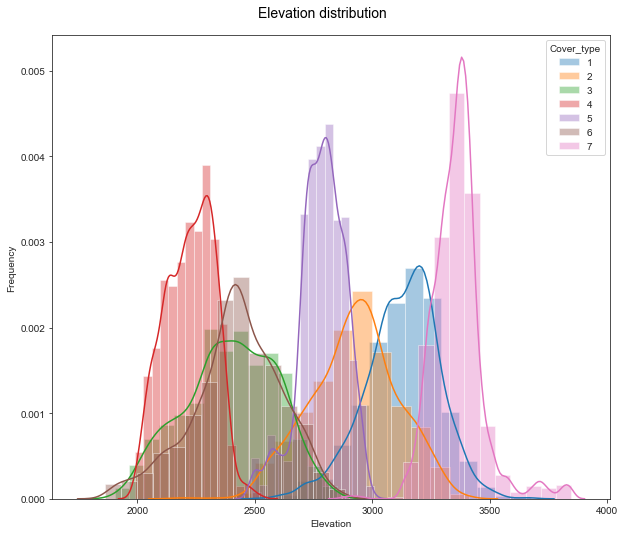

In [7]:
#plot the Elevetion frequency with seabron for each Target

fig = plt.figure(figsize=(10,8))
title = fig.suptitle("Elevation distribution", fontsize=14)
fig.subplots_adjust(top=0.93, wspace=0.3)
sns.set_style("ticks")

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Elevation")
ax.set_ylabel("Frequency") 

g = sns.FacetGrid(data=df_train[['Cover_Type','Elevation']], hue='Cover_Type')

g.map(sns.distplot, 'Elevation', kde=True, bins=15, ax=ax)

ax.legend(title='Cover_type')
plt.close(2)

In [17]:
#plot histogram of Elevation for each target with plot.ly

trace = []
for i in range(1,len(df_train['Cover_Type'].unique())+1):
    trace.append(go.Histogram(x=df_train[df_train['Cover_Type']==i]['Elevation'],opacity=0.75))

layout = go.Layout(barmode='overlay')

fig = go.Figure(data=trace, layout=layout)

plotly.offline.iplot(fig)

In [14]:
#plot the Elevetion frequency with plot.ly for each Target

trace = []
group_labels = []

for i in range(1,len(df_train['Cover_Type'].unique())+1):
    trace.append(df_train[df_train['Cover_Type']==i]['Elevation'])
    group_labels.append(i)


fig['layout'].update(title='Distplot')
fig = ff.create_distplot(trace, group_labels, bin_size=20)

# Plot!
plotly.offline.iplot(fig, filename='Distplot with Multiple Datasets')

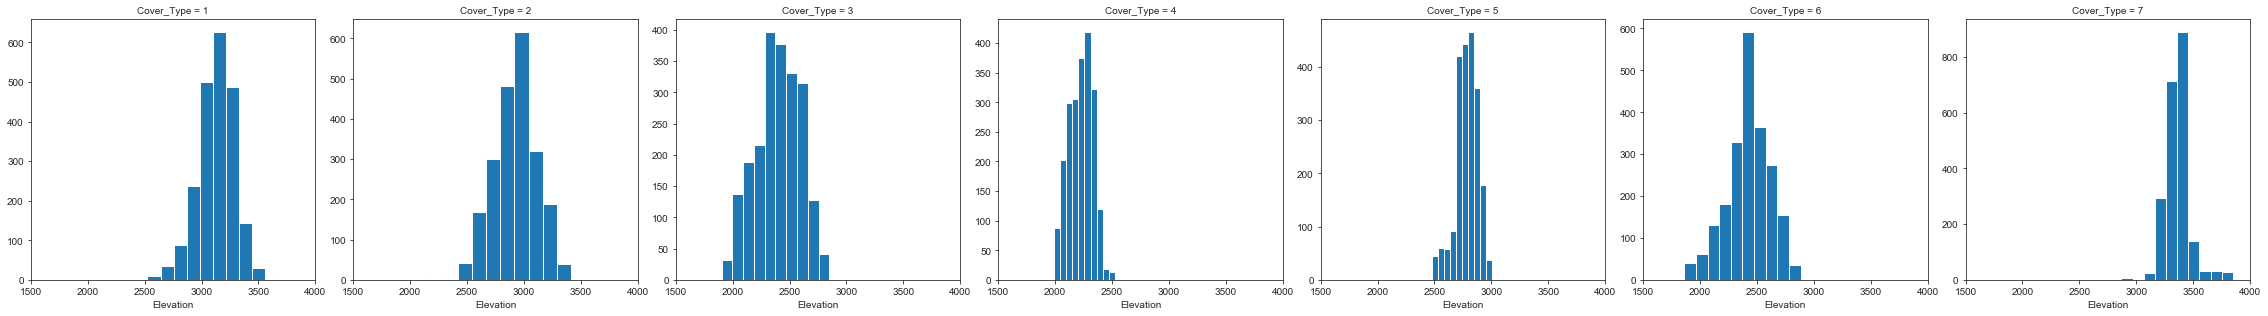

In [21]:
#plot histogram of Elevation for each Target

g = sns.FacetGrid(df_train, col="Cover_Type", height=4.5, sharex=False, sharey=False, despine=False)

# Draw a scatterplot onto each axes in the grid
g.map(plt.hist,'Elevation')
g.set(xlim=(1500,4000))

In [22]:
#histograms of train vs test

def compare_dist(ax, feature, i=0):
    sns.kdeplot(df_train[feature], label="train", ax=ax)
    sns.kdeplot(df_test[feature], label="test", ax=ax)


def numeric_tile(plot_func):
    fig, axs = plt.subplots(2, 5, figsize=(24, 6))
    axs = axs.flatten()
    
    for i, (ax, col) in enumerate(zip(axs, df_train.columns.tolist()[1:11])):
        plot_func(ax, col, i)
        ax.set_title(col)
    plt.tight_layout()

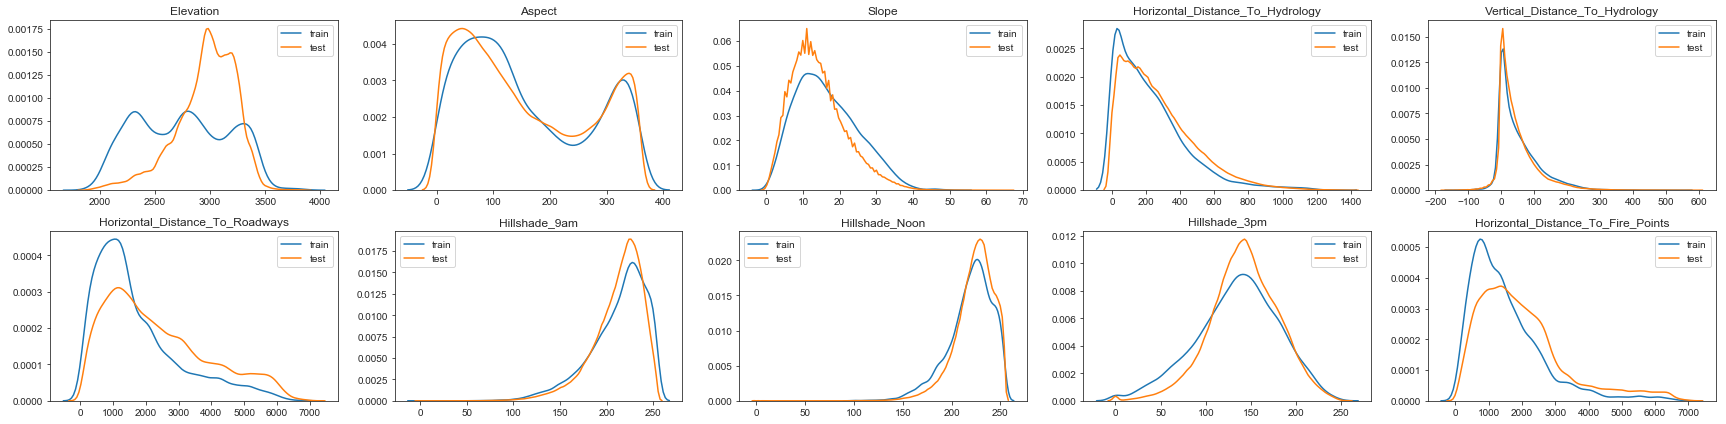

In [23]:
numeric_tile(compare_dist)

In [24]:
trace = []
name = []


for i in range(1,len(df_train.columns.tolist()[1:11])+1):
    trace.append(go.Histogram(x = df_train.iloc[:,i],nbinsx=30))
    name.append(df_train.columns.tolist()[1:11][i-1])

    
fig = tools.make_subplots(rows=2, cols=5,subplot_titles = name )

for k in range(10):
    fig['layout'].annotations[k]['font'].update(size=10)

fig['layout'].update(showlegend=False)



m = 0
#row
for x in range(1,3):
    #column
    for n in range(1,6):
        fig.append_trace(trace[m], x, n)
        m = m + 1


plotly.offline.iplot(fig, filename='custom binning')
    

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]    [ (1,5) x5,y5 ]  
[ (2,1) x6,y6 ]    [ (2,2) x7,y7 ]    [ (2,3) x8,y8 ]    [ (2,4) x9,y9 ]    [ (2,5) x10,y10 ]



In [25]:
trace = []

for i in range(1,len(df_train.columns.tolist()[1:11])+1):
    trace.append(go.Box(y = df_train.iloc[:,i],name=df_train.columns.tolist()[1:11][i-1]))

layout = go.Layout(showlegend=False, xaxis = dict(tickfont=dict(size=7)))

fig = go.Figure(data=trace, layout=layout)

plotly.offline.iplot(fig, filename="Box Plot Styling Outliers")

In [26]:
#dataframe subset to select the Soils without targets
df_soils = df_train.groupby(['Cover_Type'])[df_train.columns[15:-1].tolist()].sum()
df_soils.head()

Soil_Type1  Soil_Type2  Soil_Type3  Soil_Type4  Soil_Type5  \
Cover_Type                                                               
1                    0           0           0           5           0   
2                    0           3          12          20           0   
3                  121         283         133         462          55   
4                  139          94         799         133          39   
5                    0          61           0         129           0   

            Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  Soil_Type10  \
Cover_Type                                                                
1                    0           0           0           1            9   
2                    7           0           1           9           81   
3                  248           0           0           0          717   
4                  244           0           0           0          170   
5                    0           0           0           0           64   

               ...       Soil_Type31  Soil_Type32  Soil_Type33  Soil_Type34  \
Cover_Type     ...                                                            
1              ...               114          230          184            0   
2              ...                97          255          184           12   
3              ...                 0            5            0            0   
4              ...                 0            0            0            0   
5              ...                87          100          115            4   

            Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  Soil_Type39  \
Cover_Type                                                                    
1                     3            0            0           80           79   
2                     1            2            0            7            3   
3                     0            0            0            0            0   
4                     0            0            0            0            0   
5                     0            0            0            0            0   

            Soil_Type40  
Cover_Type               
1                    49  
2                     3  
3                     0  
4                     0  
5                     0  

[5 rows x 40 columns]

In [27]:
trace = []
name = []

for i in range(len(df_soils.index.values)):
    trace.append(go.Bar(x = df_soils.columns,y=df_soils.iloc[i]))
    name.append('Target '+str(df_soils.index.values[i]))

   
fig = tools.make_subplots(rows=7, cols=1,subplot_titles = name )


for k in range(7):
    fig['layout'].annotations[k]['font'].update(size=10)
    

fig['layout'].update(showlegend=False)
fig['layout'].update(height=1500, width=1000, title='Target Counts per Soil_Type')



m = 0
#row
for x in range(1,8):
    #column
    for n in range(1,2):
        fig.append_trace(trace[m], x, n)
        m = m + 1


plotly.offline.iplot(fig) 

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]
[ (5,1) x5,y5 ]
[ (6,1) x6,y6 ]
[ (7,1) x7,y7 ]



In [28]:
df_train_soil = df_train.iloc[:,15:-1]
df_train_soil.head()

Soil_Type1  Soil_Type2  Soil_Type3  Soil_Type4  Soil_Type5  Soil_Type6  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   Soil_Type7  Soil_Type8  Soil_Type9  Soil_Type10     ...       Soil_Type31  \
0           0           0           0            0     ...                 0   
1           0           0           0            0     ...                 0   
2           0           0           0            0     ...                 0   
3           0           0           0            0     ...                 0   
4           0           0           0            0     ...                 0   

   Soil_Type32  Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type37  Soil_Type38  Soil_Type39  Soil_Type40  
0            0            0            0            0  
1            0            0            0            0  
2            0            0            0            0  
3            0            0            0            0  
4            0            0            0            0  

[5 rows x 40 columns]

In [29]:
dict_count_soils = {}

for m in range(len(df_train_soil)):
    if ((df_train_soil.iloc[m]==1).sum()) != 1:
        dict_count_soils[m] = (df_train_soil.iloc[m]==1).sum()
        
if dict_count_soils == {}:
    print ('No hi ha Soils repetits per cada row')
else:
    dict_count_soils


No hi ha Soils repetits per cada row


In [30]:
#Are the columns soils empty??
df_train_soil.columns[df_train_soil.apply(pd.value_counts).isnull().any()].tolist()

#we observe that Soil_Type7 and Soil_Type15 are empty

['Soil_Type7', 'Soil_Type15']

In [31]:
#dataframe subset to select the Soils without targets
df_wilderness = df_train.groupby(['Cover_Type'])[df_train.columns[11:15].tolist()].sum()
df_wilderness.head()

Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  \
Cover_Type                                                         
1                       1062               181               917   
2                       1134                66               940   
3                          0                 0               863   
4                          0                 0                 0   
5                        856                 0              1304   

            Wilderness_Area4  
Cover_Type                    
1                          0  
2                         20  
3                       1297  
4                       2160  
5                          0

In [32]:
trace = []
name = []

for i in range(len(df_wilderness.index.values)):
    trace.append(go.Bar(x = df_wilderness.columns,y=df_wilderness.iloc[i]))
    name.append('Target '+str(df_wilderness.index.values[i]))

   
fig = tools.make_subplots(rows=7, cols=1,subplot_titles = name )


for k in range(7):
    fig['layout'].annotations[k]['font'].update(size=10)
    

fig['layout'].update(showlegend=False)
fig['layout'].update(height=1000, width=600, title='Target Counts per Wilderness')



m = 0
#row
for x in range(1,8):
    #column
    for n in range(1,2):
        fig.append_trace(trace[m], x, n)
        m = m + 1


plotly.offline.iplot(fig) 

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]
[ (5,1) x5,y5 ]
[ (6,1) x6,y6 ]
[ (7,1) x7,y7 ]



# Model and prediction

In [53]:
X = df_train.drop(['Cover_Type','Id'],axis=1)
y = df_train['Cover_Type']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=21,stratify=y)

In [55]:
param_grid = {'n_estimators':np.arange(1,100)}
random_forest = RandomForestClassifier()
rnd_cv = GridSearchCV(random_forest,param_grid,cv=5)

In [56]:
rnd_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([ 1,  2, ..., 98, 99])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [57]:
rnd_cv.best_params_

{'n_estimators': 69}

In [58]:
rnd_cv.best_score_

0.8535879629629629

In [69]:
rnd = RandomForestClassifier(n_estimators=69)
rnd.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=69, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
y_pred = rnd.predict(X_test)

In [71]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.76      0.74      0.75       432
           2       0.77      0.68      0.72       432
           3       0.85      0.82      0.84       432
           4       0.93      0.97      0.95       432
           5       0.89      0.93      0.91       432
           6       0.84      0.86      0.85       432
           7       0.92      0.96      0.94       432

   micro avg       0.85      0.85      0.85      3024
   macro avg       0.85      0.85      0.85      3024
weighted avg       0.85      0.85      0.85      3024

